# CRA Analysis

## Primary Functions

In [1]:
# Task Vector Threshold
EPSILON = 6e-5

In [2]:
import torch
from diffusers import StableDiffusionPipeline
import math

# Load base model for comparison
uc_pipeline = StableDiffusionPipeline.from_pretrained(
    '/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/UnlearningMethods/base_models/UnlearnCanvas',
    torch_dtype=torch.float32,
    safety_checker=None,
    requires_safety_checker=False
)
uc_unet_sd = uc_pipeline.unet.state_dict()

/users/PAS2099/justinhylee135/anaconda3/envs/cuig/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/users/PAS2099/justinhylee135/anaconda3/envs/cuig/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/users/PAS2099/justinhylee135/anaconda3/envs/cuig/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/users/PAS2099/justinhylee135/anaconda3/envs/cuig/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
An error occurred while trying to fetch /users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/UnlearningMethods/base_models/UnlearnCanvas/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /users/PAS2099/justinhylee135/Research/Unlearning

In [3]:
def compare(ft_model_list, uc_model, results):
    for name, path in ft_model_list:
        if name not in results:
            results[name] = {}
            ft_model = torch.load(path, map_location='cpu')
            if 'unet' in ft_model: ft_model = ft_model['unet']

            num_changed = 0
            total_params = 0
            total_l2_diff = 0
            total_l1_diff = 0
            
            min_diff = float('inf')
            max_diff = float('-inf')
            
            for key in ft_model.keys():
                total_params += ft_model[key].numel()
                diff = torch.abs(ft_model[key] - uc_model[key])
                diff_filtered = diff[diff > EPSILON]
                
                if diff_filtered.numel() == 0:
                    continue
                
                total_l1_diff += diff_filtered.sum().item()
                total_l2_diff += (diff_filtered ** 2).sum().item()
                num_changed += torch.sum(diff_filtered > EPSILON).item()

                min_diff = min(min_diff, diff_filtered.min().item())
                max_diff = max(max_diff, diff_filtered.max().item())


            results[name]["percent_updated"] = num_changed / total_params
            results[name]["magnitude_l1"] = total_l1_diff
            results[name]["magnitude_l2"] = total_l2_diff
            
            results[name]["min_diff"] = min_diff
            results[name]["max_diff"] = max_diff
            results[name]["mean_diff"] = total_l1_diff / num_changed if num_changed > 0 else 0
            results[name]["std_diff"] = math.sqrt((total_l2_diff / num_changed) - (results[name]["mean_diff"] ** 2)) if num_changed > 0 else 0


        print(f"{name}:")
        print(f"\tUpdated: {results[name]['percent_updated']:.2%}")
        print(f"\tL1 Magnitude: {results[name]['magnitude_l1']:,.4f}")
        print(f"\tL2 Magnitude: {results[name]['magnitude_l2']:,.4f}")
        print(f"\tMin Diff: {results[name]['min_diff']:.6f}")
        print(f"\tMax Diff: {results[name]['max_diff']:.6f}")
        print(f"\tMean Diff: {results[name]['mean_diff']:.6f}")
        print(f"\tStd Diff: {results[name]['std_diff']:.6f}")

In [4]:
import matplotlib.pyplot as plt

def plot_comparison_results(comparison_results):
    names = list(comparison_results.keys())
    x = list(range(1, len(names) + 1))

    percent_vals  = [comparison_results[name]["percent_updated"] for name in names]
    max_vals  = [comparison_results[name]["max_diff"] for name in names]
    mean_vals = [comparison_results[name]["mean_diff"] for name in names]
    l1_vals   = [comparison_results[name]["magnitude_l1"] for name in names]
    l2_vals   = [comparison_results[name]["magnitude_l2"] for name in names]
    std_vals  = [comparison_results[name]["std_diff"] for name in names]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # Plot 1: Percent updated
    axes[0].plot(x, percent_vals, marker='o')
    axes[0].set_title("Percent Updated per Model")
    axes[0].set_xlabel("Model Index (1-12)")
    axes[0].set_ylabel("Percent Updated")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(names, rotation=45, ha='right')

    # Plot 2: Max diff
    axes[1].plot(x, max_vals, marker='o', color='red')
    axes[1].set_title("Max Difference per Model")
    axes[1].set_xlabel("Model Index (1-12)")
    axes[1].set_ylabel("Max Diff")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(names, rotation=45, ha='right')

    # Plot 3: Mean diff
    axes[2].plot(x, mean_vals, marker='o', color='green')
    axes[2].set_title("Mean Difference per Model")
    axes[2].set_xlabel("Model Index (1-12)")
    axes[2].set_ylabel("Mean Diff")
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(names, rotation=45, ha='right')

    # Plot 4: L1 Magnitude
    axes[3].plot(x, l1_vals, marker='o', color='purple')
    axes[3].set_title("L1 Magnitude per Model")
    axes[3].set_xlabel("Model Index (1-12)")
    axes[3].set_ylabel("L1 Magnitude")
    axes[3].set_xticks(x)
    axes[3].set_xticklabels(names, rotation=45, ha='right')

    # Plot 5: L2 Magnitude
    axes[4].plot(x, l2_vals, marker='o', color='orange')
    axes[4].set_title("L2 Magnitude per Model")
    axes[4].set_xlabel("Model Index (1-12)")
    axes[4].set_ylabel("L2 Magnitude")
    axes[4].set_xticks(x)
    axes[4].set_xticklabels(names, rotation=45, ha='right')

    # Plot 6: Std Diff
    axes[5].plot(x, std_vals, marker='o', color='brown')
    axes[5].set_title("Standard Deviation of Diff per Model")
    axes[5].set_xlabel("Model Index (1-12)")
    axes[5].set_ylabel("Std Diff")
    axes[5].set_xticks(x)
    axes[5].set_xticklabels(names, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()


## CA Style

In [4]:
style_model_ft_list = [
            ('l1', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruVibrant_Flow/delta.bin'),
            ('l1_base', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50_base/thruVibrant_Flow/delta.bin'),
            ('l2', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/style/25000/thruVibrant_Flow/delta.bin'),
            ('selft', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/style/0.05/thruVibrant_Flow/delta.bin'),
            ('proj', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/projection/style/gradient_projection_200prompts/thruVibrant_Flow/delta.bin'),
            ('merge', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/independent/merge/style/ties/lambda2.50_topk0.40/thruVibrant_Flow.pth'),
            ('sim', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/simultaneous/base/style/early_stopping/thruVibrant_Flow/delta.bin')
            ]

In [5]:
style_results = {}

In [6]:
compare(style_model_ft_list, uc_unet_sd, style_results)

/tmp/ipykernel_1710420/530930425.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load(path, map_location='cpu')


l1:
	Updated: 20.29%
	L1 Magnitude: 2,880.1172
	L2 Magnitude: 8.6745
l1_base:
	Updated: 18.88%
	L1 Magnitude: 2,392.6198
	L2 Magnitude: 8.1557
l2:
	Updated: 82.45%
	L1 Magnitude: 10,768.9363
	L2 Magnitude: 17.9399
selft:
	Updated: 31.27%
	L1 Magnitude: 6,305.9247
	L2 Magnitude: 18.9304
proj:
	Updated: 98.12%
	L1 Magnitude: 41,631.4694
	L2 Magnitude: 154.6421
merge:
	Updated: 98.53%
	L1 Magnitude: 36,443.4011
	L2 Magnitude: 79.4768
sim:
	Updated: 93.88%
	L1 Magnitude: 13,246.4414
	L2 Magnitude: 16.5922


## CA Object

In [7]:
object_model_ft_list = [
            ('l1', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruWaterfalls/delta.bin'),
            ('l2', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruWaterfalls/delta.bin'),
            ('selft', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruWaterfalls/delta.bin'),
            ('proj', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/projection/object/gradient_projection_200prompts/thruWaterfalls/delta.bin'),
            ('merge', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/independent/merge/object/ties/lambda1.75_topk0.20/thruWaterfalls.pth'),
            ('sim', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/simultaneous/base/object/early_stopping/thruWaterfalls/delta.bin')
            ]

In [8]:
object_results = {}

In [9]:
compare(object_model_ft_list, uc_unet_sd, object_results)

/tmp/ipykernel_1710420/530930425.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load(path, map_location='cpu')


l1:
	Updated: 8.99%
	L1 Magnitude: 3,107.1568
	L2 Magnitude: 14.5649
l2:
	Updated: 69.39%
	L1 Magnitude: 7,398.8059
	L2 Magnitude: 15.1020
selft:
	Updated: 49.28%
	L1 Magnitude: 11,139.4710
	L2 Magnitude: 52.5345
proj:
	Updated: 98.71%
	L1 Magnitude: 61,285.7667
	L2 Magnitude: 329.2893
merge:
	Updated: 88.18%
	L1 Magnitude: 54,817.3338
	L2 Magnitude: 200.3731
sim:
	Updated: 95.48%
	L1 Magnitude: 20,888.7163
	L2 Magnitude: 44.4648


In [10]:
test_model_ft_list = [
            ('base', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/base/style/no_retention/thruByzantine/delta.bin'),
            ('inverse_ewc', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/inverse_ewc/style/10.0/thruByzantine_FIM.pth'),
            ('traj', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/trajectory/style/100.0/thruByzantine/delta.bin'),
            ('l1', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruByzantine/delta.bin'),
            ('l1_base', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50_base/thruByzantine/delta.bin'),
            ('l2', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/style/25000/thruByzantine/delta.bin'),
            ('selft', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/style/0.05/thruByzantine/delta.bin'),
            ('sim', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/simultaneous/base/style/early_stopping/thruByzantine/delta.bin'),
            ('proj', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/projection/style/gradient_projection_200prompts/thruByzantine/delta.bin'),
            ('merge', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/independent/merge/style/ties/lambda1.25_topk0.20/thruByzantine.pth')
            ]

In [11]:
test_results = {}

In [12]:
compare(test_model_ft_list, uc_unet_sd, test_results)

/tmp/ipykernel_1710420/530930425.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load(path, map_location='cpu')


base:
	Updated: 93.85%
	L1 Magnitude: 13,023.4030
	L2 Magnitude: 15.3090
inverse_ewc:
	Updated: 99.86%
	L1 Magnitude: 627,425.8010
	L2 Magnitude: 35,801.7660
traj:
	Updated: 4.69%
	L1 Magnitude: 859.7154
	L2 Magnitude: 1.6932
l1:
	Updated: 3.49%
	L1 Magnitude: 499.5428
	L2 Magnitude: 0.8676
l1_base:
	Updated: 3.73%
	L1 Magnitude: 506.8884
	L2 Magnitude: 0.8448
l2:
	Updated: 50.17%
	L1 Magnitude: 2,160.9035
	L2 Magnitude: 1.0488
selft:
	Updated: 8.23%
	L1 Magnitude: 1,749.9264
	L2 Magnitude: 3.0204
sim:
	Updated: 89.52%
	L1 Magnitude: 7,289.8222
	L2 Magnitude: 4.6485
proj:
	Updated: 93.89%
	L1 Magnitude: 13,093.7911
	L2 Magnitude: 15.4744
merge:
	Updated: 0.79%
	L1 Magnitude: 8,105.0880
	L2 Magnitude: 11.1314


# Update Overlap

In [13]:
model_1 = torch.load('/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruVibrant_Flow/delta.bin', map_location='cpu')['unet']
model_2 = torch.load('/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50_base/thruVibrant_Flow/delta.bin', map_location='cpu')['unet']

avg_overlap = 0
for key in model_1.keys():
    diff_l1 = torch.abs(model_1[key] - uc_unet_sd[key])
    mask_l1 = diff_l1 > EPSILON

    diff_selft = torch.abs(model_2[key] - uc_unet_sd[key])
    mask_selft = diff_selft > EPSILON

    mask_union = mask_l1 | mask_selft
    mask_intersection = mask_l1 & mask_selft
    overlap = torch.sum(mask_intersection).item() / (torch.sum(mask_union).item() or 1)
    avg_overlap += overlap
    print(f"{key}: Overlap: {overlap:.2%}")
avg_overlap /= len(model_1.keys())
print(f"Average Overlap: {avg_overlap:.2%}")


/tmp/ipykernel_1710420/3557232054.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1 = torch.load('/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style

down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_k.weight: Overlap: 35.10%
down_blocks.0.attentions.0.transformer_blocks.0.attn2.to_v.weight: Overlap: 61.76%
down_blocks.0.attentions.1.transformer_blocks.0.attn2.to_k.weight: Overlap: 31.49%
down_blocks.0.attentions.1.transformer_blocks.0.attn2.to_v.weight: Overlap: 40.63%
down_blocks.1.attentions.0.transformer_blocks.0.attn2.to_k.weight: Overlap: 41.13%
down_blocks.1.attentions.0.transformer_blocks.0.attn2.to_v.weight: Overlap: 60.69%
down_blocks.1.attentions.1.transformer_blocks.0.attn2.to_k.weight: Overlap: 38.14%
down_blocks.1.attentions.1.transformer_blocks.0.attn2.to_v.weight: Overlap: 38.93%
down_blocks.2.attentions.0.transformer_blocks.0.attn2.to_k.weight: Overlap: 42.50%
down_blocks.2.attentions.0.transformer_blocks.0.attn2.to_v.weight: Overlap: 59.53%
down_blocks.2.attentions.1.transformer_blocks.0.attn2.to_k.weight: Overlap: 45.09%
down_blocks.2.attentions.1.transformer_blocks.0.attn2.to_v.weight: Overlap: 55.13%
up_b

In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np
style_model = torch.load('/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruVibrant_Flow/delta.bin', map_location='cpu')['unet']
object_model = torch.load('/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruWaterfalls/delta.bin', map_location='cpu')['unet']

style_magnitudes = {}
object_magnitudes = {}

# Compute absolute diffs
for key in style_model.keys():
    diff_style = torch.abs(style_model[key] - uc_unet_sd[key])
    style_magnitudes[key] = diff_style.sum().item()

    diff_object = torch.abs(object_model[key] - uc_unet_sd[key])
    object_magnitudes[key] = diff_object.sum().item()

# Normalize to percentages of total magnitude
total_style = sum(style_magnitudes.values())
total_object = sum(object_magnitudes.values())

style_percentages = {k: (v / total_style) * 100 for k, v in style_magnitudes.items()}
object_percentages = {k: (v / total_object) * 100 for k, v in object_magnitudes.items()}

/tmp/ipykernel_1710420/535845219.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  style_model = torch.load('/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/st

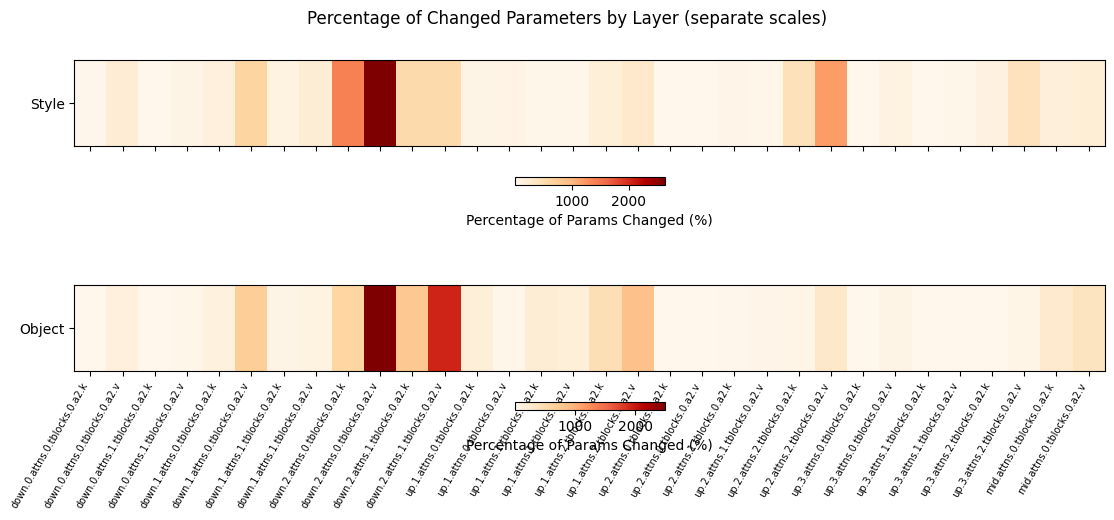

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- assume these exist ---
# style_percentages: dict[str, float]  # 0..1
# object_percentages: dict[str, float] # 0..1

# Consistent ordering of layers
keys = list(style_percentages.keys())

# Build 2 x N matrix, convert to %
data = np.array([
    [style_percentages[k] * 100 for k in keys],
    [object_percentages[k] * 100 for k in keys],
])

# Optional: abbreviate long layer names (edit as you like)
def short(k: str) -> str:
    k = k.replace("transformer_blocks", "tblocks")
    k = k.replace("attention", "attn")
    k = k.replace("attn2", "a2")
    k = k.replace("attn1", "a1")
    k = k.replace("down_blocks", "down")
    k = k.replace("up_blocks", "up")
    k = k.replace("mid_block", "mid")
    k = k.replace("to_k.weight", "k")
    k = k.replace("to_v.weight", "v")
    return k

short_keys = [short(k) for k in keys]

# Plot
fig, axes = plt.subplots(
    2, 1, figsize=(max(10, len(keys) * 0.35), 5), sharex=True, constrained_layout=False
)

row_labels = ["Style", "Object"]

for i, ax in enumerate(axes):
    row = data[i]
    vmin, vmax = row.min(), row.max()  # separate scale per row
    im = ax.imshow(row[np.newaxis, :], cmap="OrRd", aspect="auto",
                   vmin=vmin, vmax=vmax)

    # Row label on the left
    ax.set_yticks([0])
    ax.set_yticklabels([row_labels[i]], fontsize=10)

    # Thin grid line to visually separate cols (optional)
    ax.set_yticks([], minor=True)

    # Per-row horizontal colorbar below the row
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal",
                        pad=0.25, fraction=0.06)
    cbar.set_label("Percentage of Params Changed (%)")

# X ticks: show fewer to avoid clutter
N = len(keys)
step = max(1, N // 30)  # show about <= 30 labels
visible_idx = np.arange(0, N, step)

axes[-1].set_xticks(visible_idx)
axes[-1].set_xticklabels([short_keys[j] for j in visible_idx],
                         rotation=60, ha="right", fontsize=7)

fig.suptitle("Percentage of Changed Parameters by Layer (separate scales)", y=0.98)
plt.subplots_adjust(top=0.88, bottom=0.18, left=0.06, right=0.98, hspace=0.8)
plt.show()

# Scratch

In [ ]:
l1_comparison_list = [('l1_Bears', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruBears/delta.bin'),
                   ('l1_Birds', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruBirds/delta.bin'),
                   ('l1_Cats', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruCats/delta.bin'),
                   ('l1_Dogs', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruDogs/delta.bin'),
                   ('l1_Fishes', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruFishes/delta.bin'),
                   ('l1_Frogs', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruFrogs/delta.bin'),
                   ('l1_Jellyfish', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruJellyfish/delta.bin'),
                   ('l1_Rabbits', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruRabbits/delta.bin'),
                   ('l1_Sandwiches', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruSandwiches/delta.bin'),
                   ('l1_Statues', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruStatues/delta.bin'),
                   ('l1_Towers', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruTowers/delta.bin'),
                   ('l1_Waterfalls', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/object/50/thruWaterfalls/delta.bin')]
l1_comparison_results = {}

In [ ]:
compare(comparison_list, uc_unet_sd, comparison_results)

/tmp/ipykernel_1420219/3569066168.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load(path, map_location='cpu')


l1_Bears:
	Updated: 2.86%
	L1 Magnitude: 665.5606
	L2 Magnitude: 1.4437
	Min Diff: 0.000060
	Max Diff: 0.008622
	Mean Diff: 0.001215
	Std Diff: 0.001077
l1_Birds:
	Updated: 4.84%
	L1 Magnitude: 1,284.6913
	L2 Magnitude: 3.3810
	Min Diff: 0.000060
	Max Diff: 0.012629
	Mean Diff: 0.001385
	Std Diff: 0.001314
l1_Cats:
	Updated: 5.57%
	L1 Magnitude: 1,625.6359
	L2 Magnitude: 4.9993
	Min Diff: 0.000060
	Max Diff: 0.019072
	Mean Diff: 0.001521
	Std Diff: 0.001538
l1_Dogs:
	Updated: 6.62%
	L1 Magnitude: 1,981.9720
	L2 Magnitude: 7.0053
	Min Diff: 0.000060
	Max Diff: 0.024732
	Mean Diff: 0.001561
	Std Diff: 0.001755
l1_Fishes:
	Updated: 7.18%
	L1 Magnitude: 2,284.2077
	L2 Magnitude: 8.7358
	Min Diff: 0.000060
	Max Diff: 0.028913
	Mean Diff: 0.001660
	Std Diff: 0.001895
l1_Frogs:
	Updated: 7.41%
	L1 Magnitude: 2,489.9299
	L2 Magnitude: 10.3745
	Min Diff: 0.000060
	Max Diff: 0.030550
	Mean Diff: 0.001752
	Std Diff: 0.002057
l1_Jellyfish:
	Updated: 7.90%
	L1 Magnitude: 2,627.1553
	L2 Magnitude: 1

/tmp/ipykernel_537178/3293426843.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  l1_comparison_results = torch.load('/users/PAS2099/justinhylee135/Research/UnlearningDM/

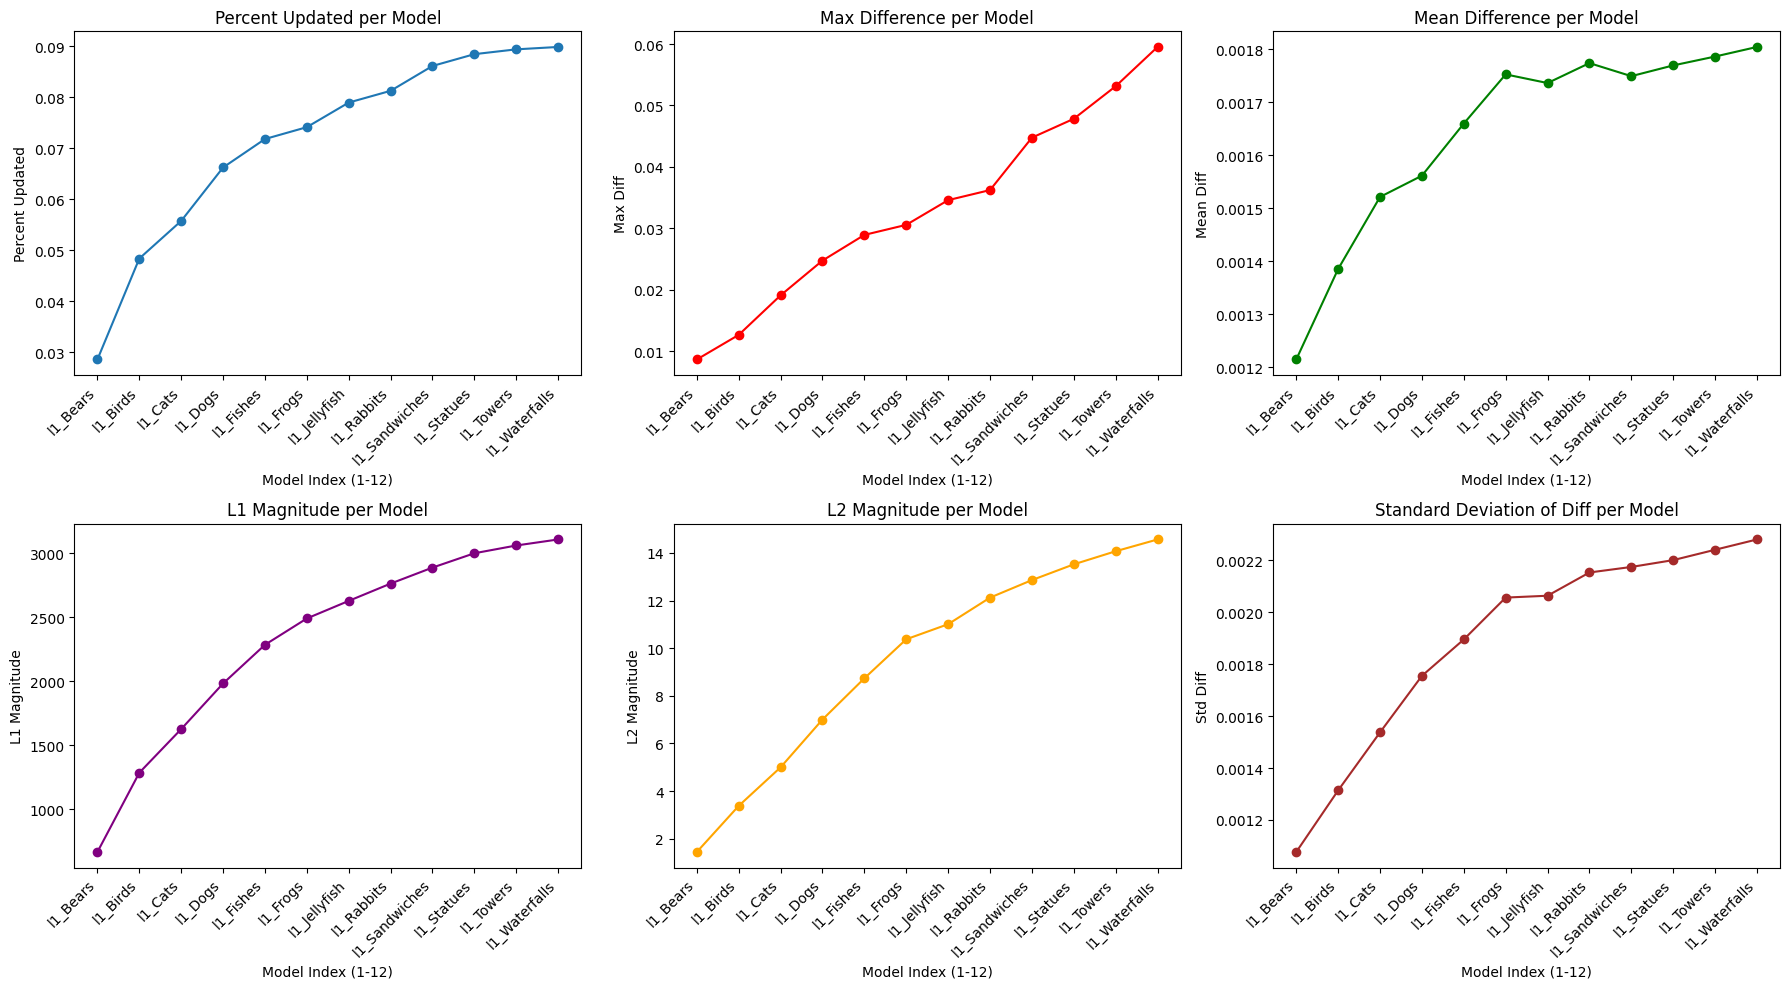

In [19]:
l1_comparison_results = torch.load('/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/notebook_output/cra_analysis/ca_l1_object.pth', map_location='cpu')
plot_comparison_results(l1_comparison_results)

In [8]:
l2_comparison_list = [('l2_Bears', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruBears/delta.bin'),
                   ('l2_Birds', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruBirds/delta.bin'),
                   ('l2_Cats', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruCats/delta.bin'),
                   ('l2_Dogs', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruDogs/delta.bin'),
                   ('l2_Fishes', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruFishes/delta.bin'),
                   ('l2_Frogs', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruFrogs/delta.bin'),
                   ('l2_Jellyfish', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruJellyfish/delta.bin'),
                   ('l2_Rabbits', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruRabbits/delta.bin'),
                   ('l2_Sandwiches', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruSandwiches/delta.bin'),
                   ('l2_Statues', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruStatues/delta.bin'),
                   ('l2_Towers', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruTowers/delta.bin'),
                   ('l2_Waterfalls', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l2sp/object/25000/thruWaterfalls/delta.bin')]
l2_comparison_results = {}

In [9]:
compare(l2_comparison_list, uc_unet_sd, l2_comparison_results)

/tmp/ipykernel_537178/3569066168.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load(path, map_location='cpu')


l2_Bears:
	Updated: 29.46%
	L1 Magnitude: 1,479.0935
	L2 Magnitude: 1.1248
	Min Diff: 0.000060
	Max Diff: 0.008283
	Mean Diff: 0.000262
	Std Diff: 0.000361
l2_Birds:
	Updated: 42.04%
	L1 Magnitude: 2,678.3016
	L2 Magnitude: 2.7798
	Min Diff: 0.000060
	Max Diff: 0.011681
	Mean Diff: 0.000332
	Std Diff: 0.000484
l2_Cats:
	Updated: 48.85%
	L1 Magnitude: 3,413.6997
	L2 Magnitude: 4.1626
	Min Diff: 0.000060
	Max Diff: 0.015389
	Mean Diff: 0.000365
	Std Diff: 0.000558
l2_Dogs:
	Updated: 55.18%
	L1 Magnitude: 4,319.1391
	L2 Magnitude: 6.0785
	Min Diff: 0.000060
	Max Diff: 0.020135
	Mean Diff: 0.000408
	Std Diff: 0.000639
l2_Fishes:
	Updated: 57.42%
	L1 Magnitude: 4,861.9502
	L2 Magnitude: 7.6820
	Min Diff: 0.000060
	Max Diff: 0.018752
	Mean Diff: 0.000442
	Std Diff: 0.000709
l2_Frogs:
	Updated: 59.43%
	L1 Magnitude: 5,273.4128
	L2 Magnitude: 9.0123
	Min Diff: 0.000060
	Max Diff: 0.020692
	Mean Diff: 0.000463
	Std Diff: 0.000760
l2_Jellyfish:
	Updated: 62.62%
	L1 Magnitude: 5,635.8086
	L2 Magn

/tmp/ipykernel_537178/1480690168.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  l2_comparison_results = torch.load('/users/PAS2099/justinhylee135/Research/UnlearningDM/

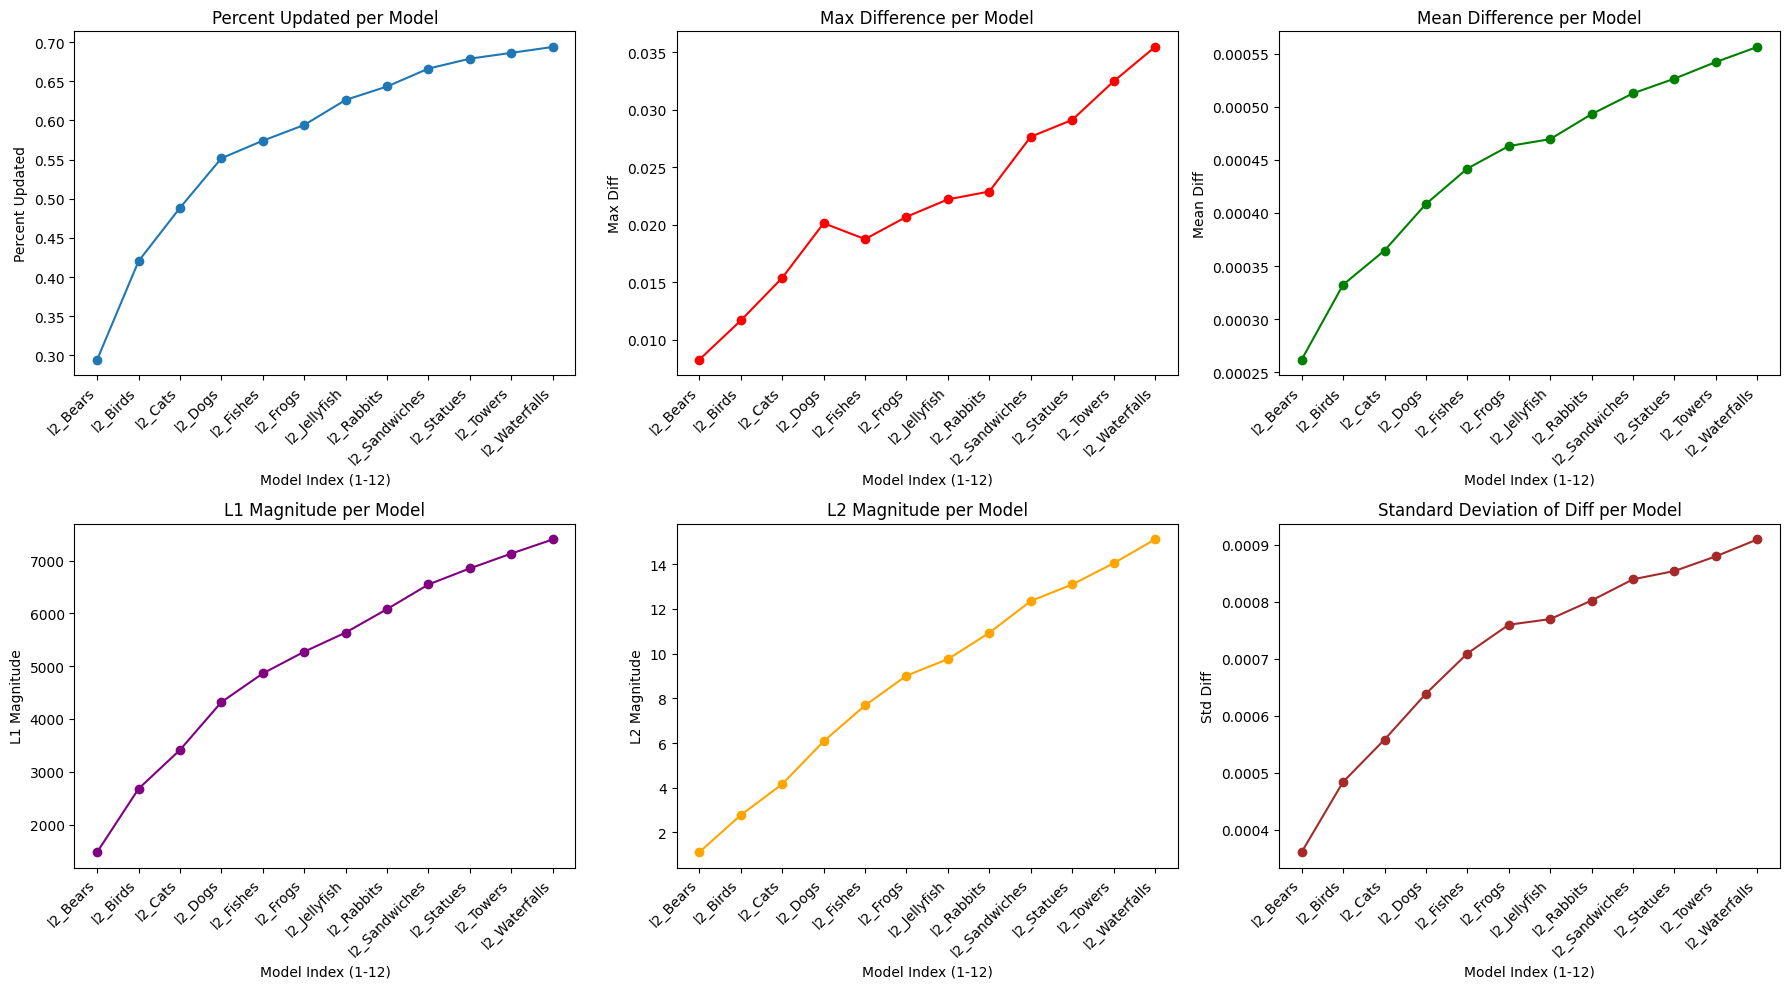

In [21]:
l2_comparison_results = torch.load('/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/notebook_output/cra_analysis/ca_l2_object.pth', map_location='cpu')
plot_comparison_results(l2_comparison_results)

In [ ]:
selft_comparison_list = [
                   ('selft_Bears', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruBears/delta.bin'),
                   ('selft_Birds', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruBirds/delta.bin'),
                   ('selft_Cats', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruCats/delta.bin'),
                   ('selft_Dogs', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruDogs/delta.bin'),
                   ('selft_Fishes', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruFishes/delta.bin'),
                   ('selft_Frogs', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruFrogs/delta.bin'),
                   ('selft_Jellyfish', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruJellyfish/delta.bin'),
                   ('selft_Rabbits', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruRabbits/delta.bin'),
                   ('selft_Sandwiches', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruSandwiches/delta.bin'),
                   ('selft_Statues', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruStatues/delta.bin'),
                   ('selft_Towers', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruTowers/delta.bin'),
                   ('selft_Waterfalls', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/selft/object/0.05/thruWaterfalls/delta.bin')]
selft_comparison_results = {}

In [66]:
compare(l2_comparison_list, uc_unet_sd, l2_comparison_results)

/tmp/ipykernel_1420219/3569066168.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load(path, map_location='cpu')


selft_Bears:
	Updated: 4.88%
	L1 Magnitude: 1,488.6794
	L2 Magnitude: 3.6895
	Min Diff: 0.000060
	Max Diff: 0.009068
	Mean Diff: 0.001592
	Std Diff: 0.001188
selft_Birds:
	Updated: 8.56%
	L1 Magnitude: 3,078.6067
	L2 Magnitude: 9.7497
	Min Diff: 0.000060
	Max Diff: 0.014777
	Mean Diff: 0.001877
	Std Diff: 0.001556
selft_Cats:
	Updated: 11.85%
	L1 Magnitude: 4,178.2871
	L2 Magnitude: 14.2916
	Min Diff: 0.000060
	Max Diff: 0.022480
	Mean Diff: 0.001840
	Std Diff: 0.001705
selft_Dogs:
	Updated: 13.70%
	L1 Magnitude: 5,234.3351
	L2 Magnitude: 20.0016
	Min Diff: 0.000060
	Max Diff: 0.025493
	Mean Diff: 0.001993
	Std Diff: 0.001909
selft_Fishes:
	Updated: 24.60%
	L1 Magnitude: 6,439.6993
	L2 Magnitude: 26.0506
	Min Diff: 0.000060
	Max Diff: 0.030514
	Mean Diff: 0.001366
	Std Diff: 0.001913
selft_Frogs:
	Updated: 25.94%
	L1 Magnitude: 7,243.1470
	L2 Magnitude: 30.6646
	Min Diff: 0.000060
	Max Diff: 0.033259
	Mean Diff: 0.001457
	Std Diff: 0.002011
selft_Jellyfish:
	Updated: 27.03%
	L1 Magnitu

/tmp/ipykernel_537178/2881246624.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  selft_comparison_results = torch.load('/users/PAS2099/justinhylee135/Research/Unlearning

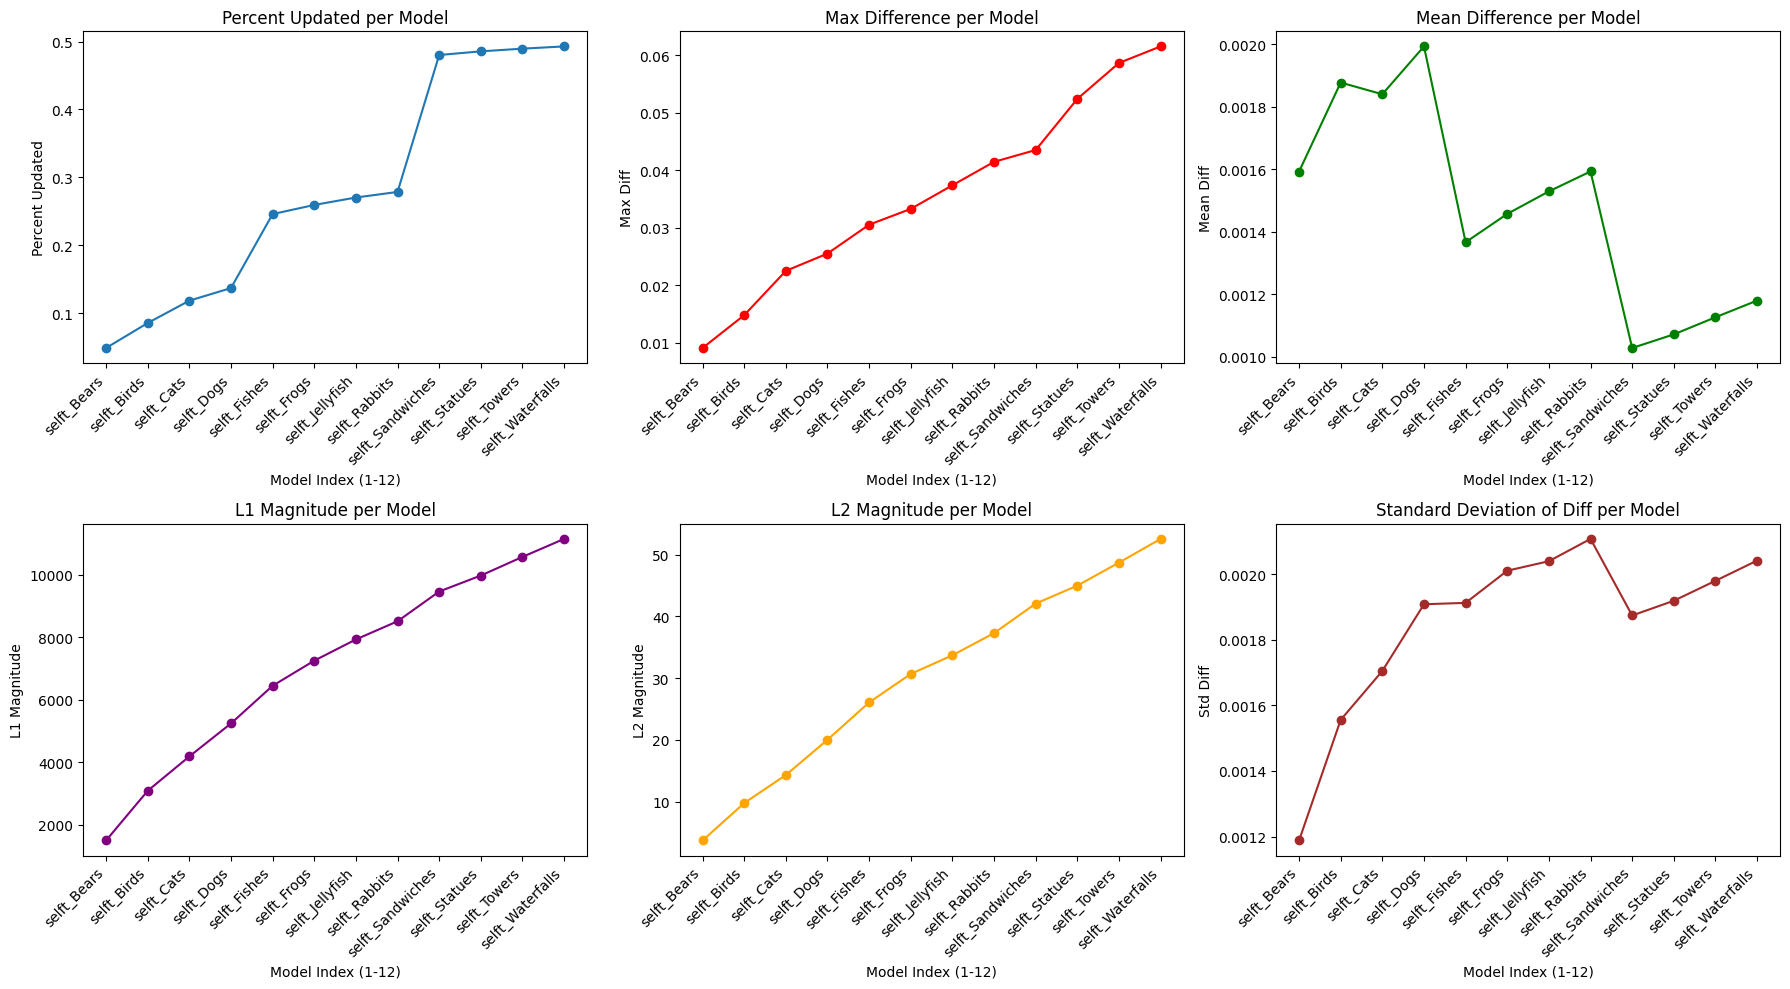

In [22]:
selft_comparison_results = torch.load('/users/PAS2099/justinhylee135/Research/UnlearningDM/CUIG/Analysis/Notebooks/notebook_output/cra_analysis/ca_selft_object.pth', map_location='cpu')
plot_comparison_results(selft_comparison_results)

In [ ]:
style_l1_comparison_list = [
                    ('l1_Abstractionism', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruAbstractionism/delta.bin'),
                    ('l1_Byzantine', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruByzantine/delta.bin'),
                    ('l1_Cartoon', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruCartoon/delta.bin'), 
                    ('l1_Cold_Warm', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruCold_Warm/delta.bin'),
                    ('l1_Ukiyoe', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruUkiyoe/delta.bin'),
                    ('l1_Van_Gogh', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruVan_Gogh/delta.bin'),
                    ('l1_Neon_Lines', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruNeon_Lines/delta.bin'),
                    ('l1_Picasso', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruPicasso/delta.bin'),
                    ('l1_On_Fire', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruOn_Fire/delta.bin'),
                    ('l1_Magic_Cube', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruMagic_Cube/delta.bin'),
                    ('l1_Winter', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruWinter/delta.bin'),
                    ('l1_Vibrant_Flow', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/continual/l1sp/style/50/thruVibrant_Flow/delta.bin'),
                    ]
style_l1_comparison_results = {}

In [ ]:
compare(style_l1_comparison_list, uc_unet_sd, style_l1_comparison_results)

/tmp/ipykernel_537178/3569066168.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load(path, map_location='cpu')


l1_Abstractionism:
	Updated: 2.42%
	L1 Magnitude: 325.7154
	L2 Magnitude: 0.4643
	Min Diff: 0.000060
	Max Diff: 0.005096
	Mean Diff: 0.000702
	Std Diff: 0.000713
l1_Byzantine:
	Updated: 3.49%
	L1 Magnitude: 499.5428
	L2 Magnitude: 0.8676
	Min Diff: 0.000060
	Max Diff: 0.009018
	Mean Diff: 0.000746
	Std Diff: 0.000860
l1_Cartoon:
	Updated: 4.52%
	L1 Magnitude: 663.3218
	L2 Magnitude: 1.4121
	Min Diff: 0.000060
	Max Diff: 0.013147
	Mean Diff: 0.000766
	Std Diff: 0.001022
l1_Cold_Warm:
	Updated: 7.28%
	L1 Magnitude: 875.5035
	L2 Magnitude: 1.9243
	Min Diff: 0.000060
	Max Diff: 0.015349
	Mean Diff: 0.000627
	Std Diff: 0.000992
l1_Ukiyoe:
	Updated: 12.05%
	L1 Magnitude: 1,281.1437
	L2 Magnitude: 2.8643
	Min Diff: 0.000060
	Max Diff: 0.017006
	Mean Diff: 0.000555
	Std Diff: 0.000966
l1_Van_Gogh:
	Updated: 13.84%
	L1 Magnitude: 1,533.4058
	L2 Magnitude: 3.6137
	Min Diff: 0.000060
	Max Diff: 0.022021
	Mean Diff: 0.000578
	Std Diff: 0.001014
l1_Neon_Lines:
	Updated: 16.31%
	L1 Magnitude: 1,900.

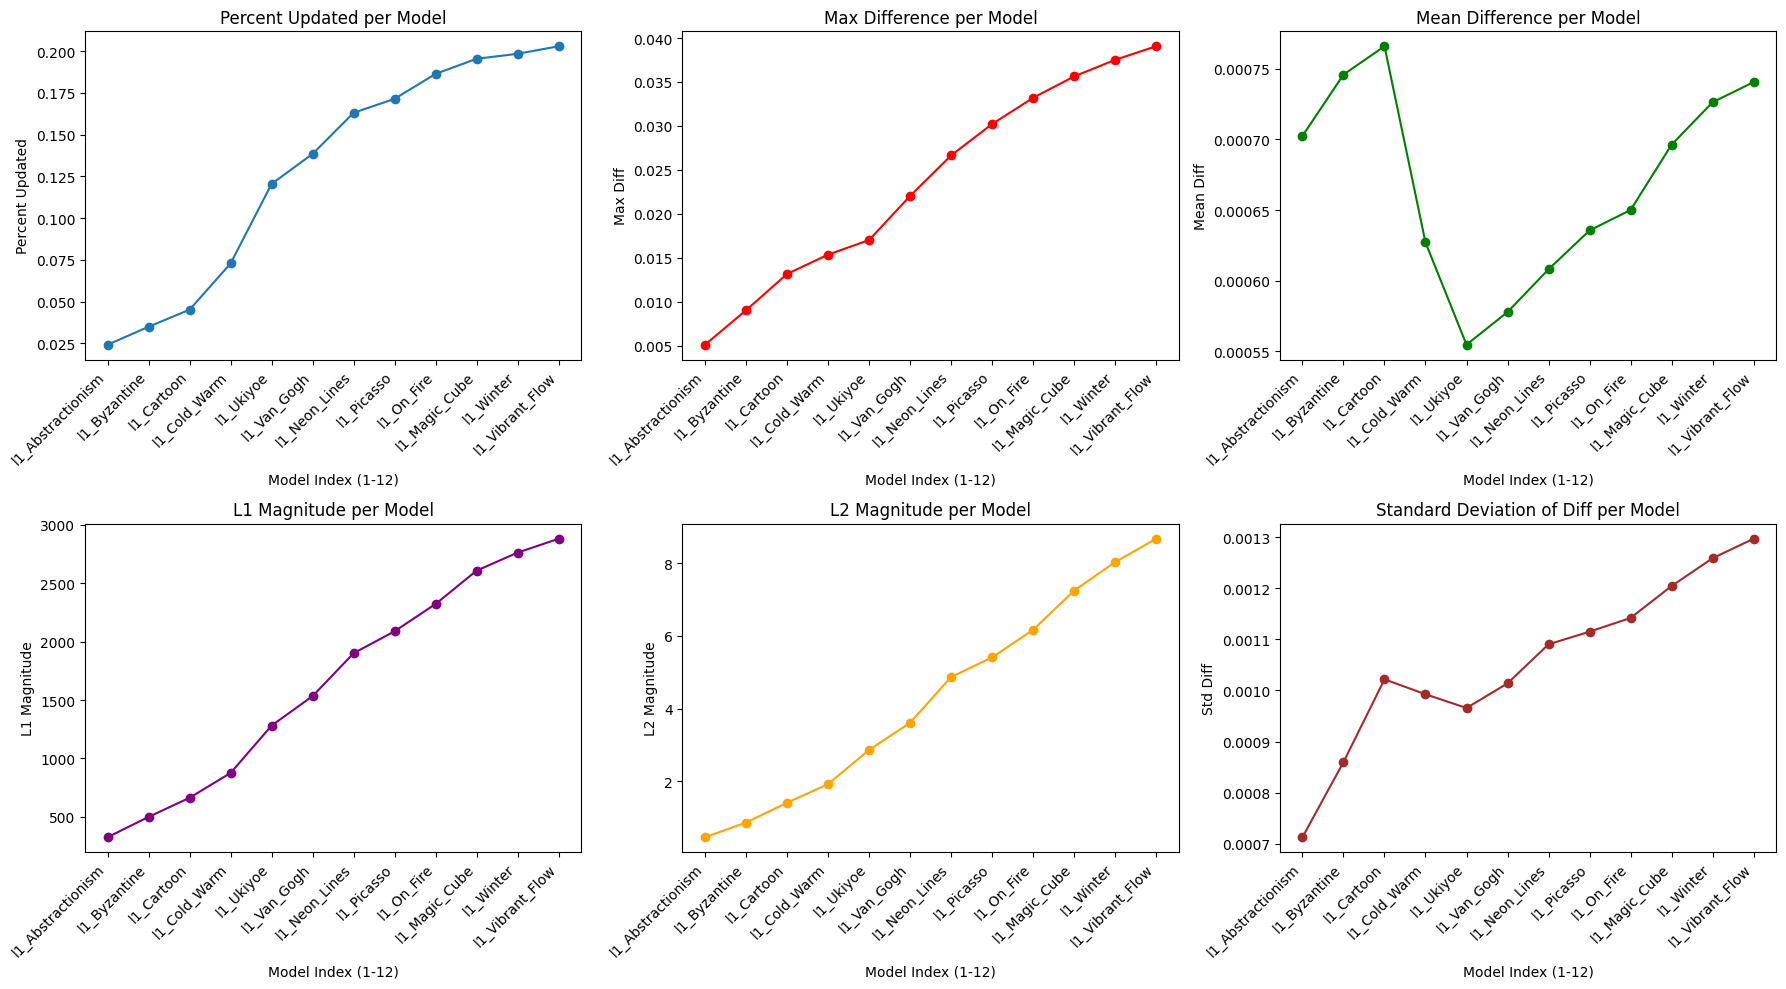

In [28]:
plot_comparison_results(style_l1_comparison_results)

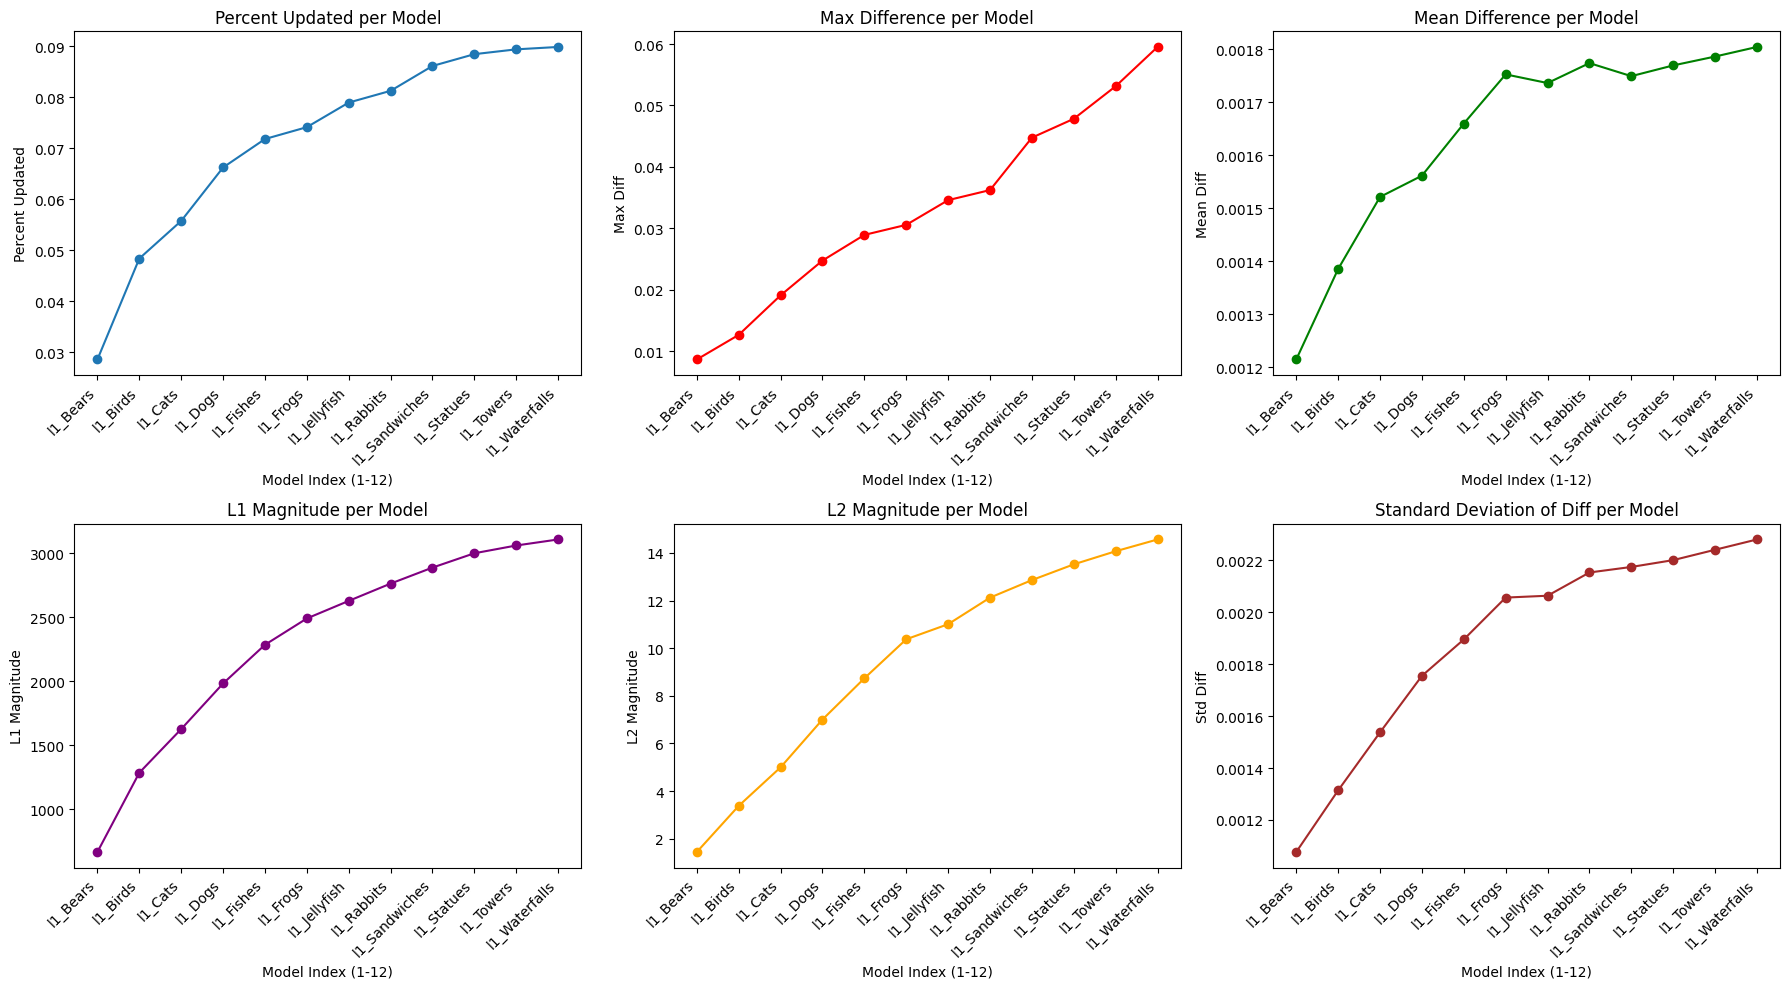

In [30]:
plot_comparison_results(object_l1_comparison_results)

/tmp/ipykernel_860259/3569066168.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load(path, map_location='cpu')


Jellyfish:
	Updated: 91.40%
	L1 Magnitude: 10,546.7910
	L2 Magnitude: 11.1809
	Min Diff: 0.000060
	Max Diff: 0.006459
	Mean Diff: 0.000602
	Std Diff: 0.000525
Rabbits:
	Updated: 91.15%
	L1 Magnitude: 10,329.3868
	L2 Magnitude: 10.8392
	Min Diff: 0.000060
	Max Diff: 0.006370
	Mean Diff: 0.000591
	Std Diff: 0.000520
Sandwiches:
	Updated: 94.00%
	L1 Magnitude: 15,528.4836
	L2 Magnitude: 24.9689
	Min Diff: 0.000060
	Max Diff: 0.011755
	Mean Diff: 0.000862
	Std Diff: 0.000802
Statues:
	Updated: 95.84%
	L1 Magnitude: 21,920.0956
	L2 Magnitude: 47.8821
	Min Diff: 0.000060
	Max Diff: 0.013630
	Mean Diff: 0.001193
	Std Diff: 0.001088
Towers:
	Updated: 94.88%
	L1 Magnitude: 18,625.5235
	L2 Magnitude: 35.7711
	Min Diff: 0.000060
	Max Diff: 0.012836
	Mean Diff: 0.001024
	Std Diff: 0.000958
Waterfalls:
	Updated: 95.48%
	L1 Magnitude: 20,888.7163
	L2 Magnitude: 44.4648
	Min Diff: 0.000060
	Max Diff: 0.013928
	Mean Diff: 0.001141
	Std Diff: 0.001062


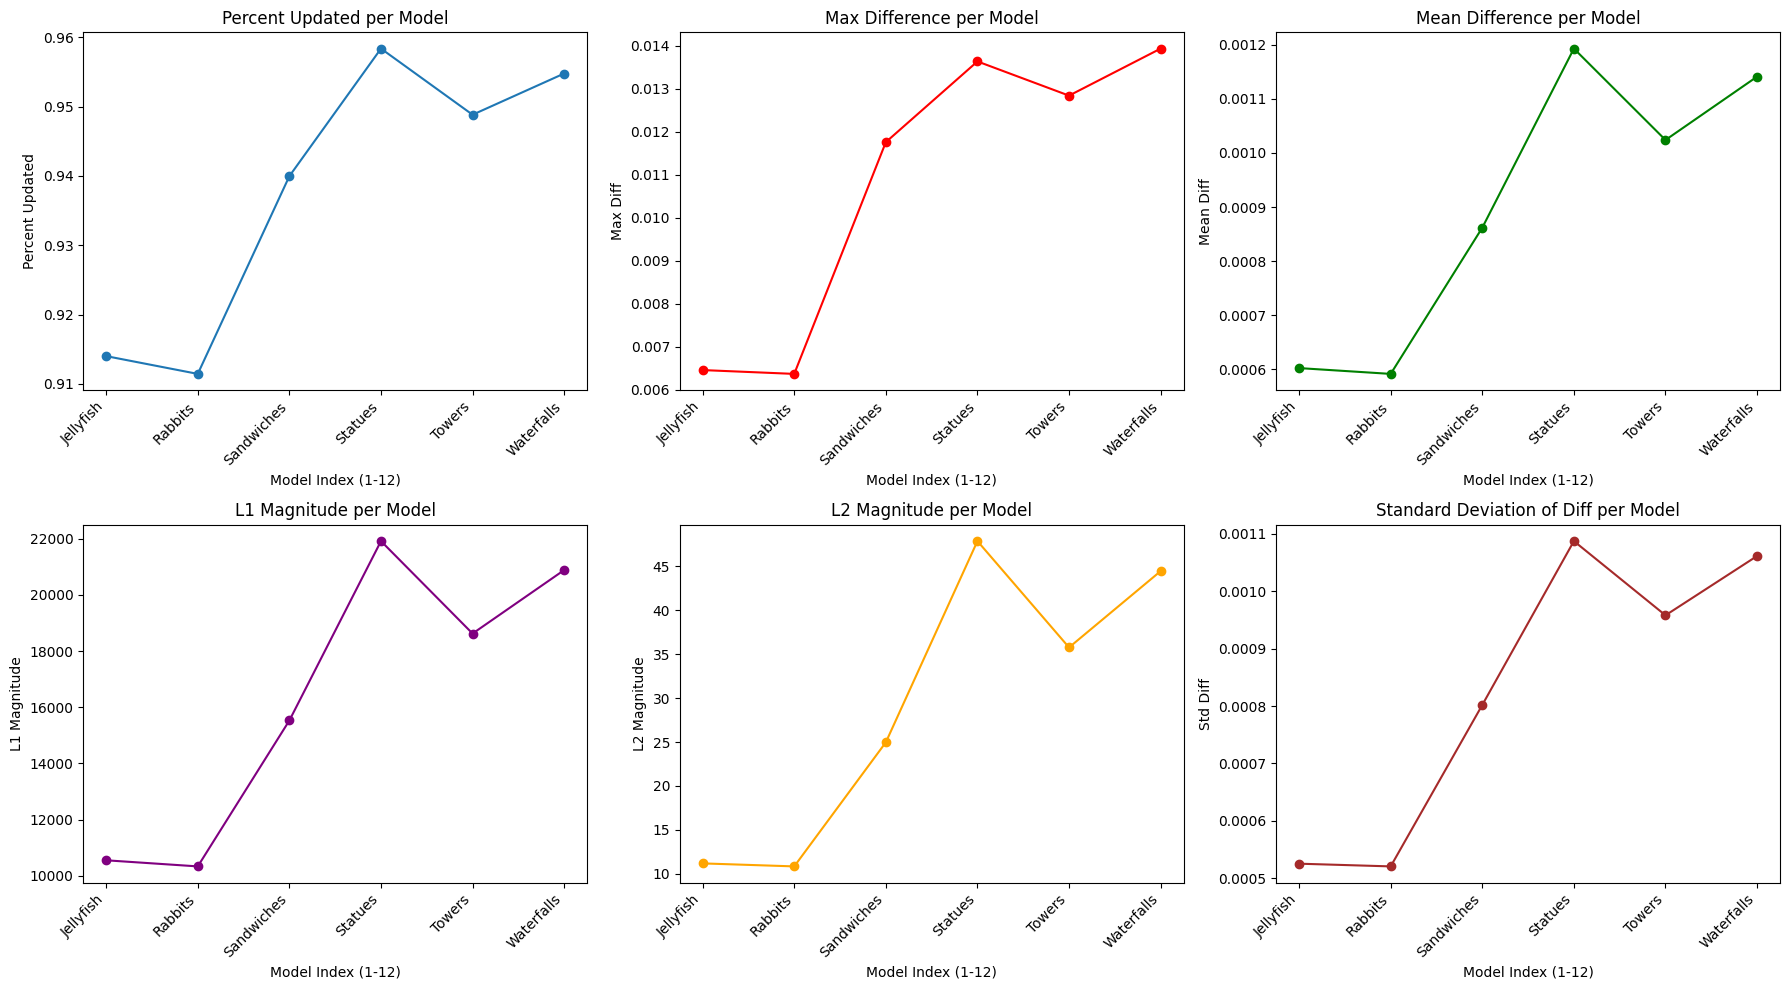

In [6]:
test_list = [('Jellyfish', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/simultaneous/base/object/early_stopping/thruJellyfish/delta.bin'),
             ('Rabbits', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/simultaneous/base/object/early_stopping/thruRabbits/delta.bin'),
             ('Sandwiches', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/simultaneous/base/object/early_stopping/thruSandwiches/delta.bin'),
             ('Statues', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/simultaneous/base/object/early_stopping/thruStatues/delta.bin'),
              ('Towers', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/simultaneous/base/object/early_stopping/thruTowers/delta.bin'),
              ('Waterfalls', '/fs/scratch/PAS2099/lee.10369/CUIG/ca/models/simultaneous/base/object/early_stopping/thruWaterfalls/delta.bin')]
test_results = {}
compare(test_list, uc_unet_sd, test_results)
plot_comparison_results(test_results)